In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [2]:
#load datasets
users = pd.read_csv('takehome_users.csv', encoding='latin1')
engagement = pd.read_csv('takehome_user_engagement.csv')

Exploratory data analysis

In [3]:
#users.head()

In [4]:
#users.info()

In [5]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
#engagement.info()

Goal is to identify which factors predict future user adoption with "adopted user" defined as user who has logged into product on three separate days in at least one seven-day period


In [7]:
grouped_engagement = engagement.groupby('user_id').count().sort_values(by = 'visited', ascending = False)

In [8]:
#check for errors. Want to show any instances where the count of timestamps is 
#different from the number of visits. This would indicate duplicates.
mask = grouped_engagement['time_stamp'] != grouped_engagement['visited']
duplicates = grouped_engagement[mask]

There appear to be no duplicates, with each user's visit mapping to a unique timestamp.

In [9]:
#Returning to the engagement dataset, we see that our time stamp column is an object 
print(engagement['time_stamp'].dtype)

object


In [10]:
#convert to datetime
engagement['time_stamp']= pd.to_datetime(engagement['time_stamp'])
print(engagement['time_stamp'].dtype)

datetime64[ns]


In [11]:
#check total time period covered by engagement df, 
engagement_first = engagement['time_stamp'].min()
engagement_last = engagement['time_stamp'].max()
print("first engagement: ", engagement_first, ", last engagement: ", engagement_last )

first engagement:  2012-05-31 08:20:06 , last engagement:  2014-06-06 14:58:50


In [12]:
#look at distributions of user info columns
#users.hist(figsize = (20,10));

## plan: use rolling window to find list of users who meet "adopter" criteria. Use pairplot to show correlation with each column

In [13]:
#set index
engagement.set_index('time_stamp', drop = True, inplace = True)
#engagement.head()

In [14]:
#sort values
engagement.sort_values(by = ['user_id','time_stamp'], inplace = True)
#engagement.head(30)

In [15]:
# Check the rolling sum calculation and structure before filtering
check_rolling = engagement.groupby('user_id').rolling(window='7D').visited.sum()
#print(check_rolling.head(20));

In [16]:
# Apply filter for adopted criteria
adopted = check_rolling[check_rolling >= 3]

In [17]:
# Reset index to make 'user_id' and 'time_stamp' regular columns again
adopted_users = adopted.reset_index()
adopted_users;

In [18]:
#Group by 'user_id' and get the maximum 'visited' count
adopted_users_max_visits = adopted_users.groupby('user_id').visited.max().reset_index()
#adopted_users_max_visits

In [19]:
adopted_users_max_visits.sort_values(by='user_id', inplace=True)
#print(adopted_users_max_visits['user_id'])

## Now we've identified the user id numbers that fit our adoption criteria. 
## Next we will merge these results with the users df to identify trends in user details and whether or not they adopt

In [20]:
#Initialize column 'is_adopter' in the users df to 0
users['is_adopter'] = 0
#print(users['is_adopter'].head());

In [28]:
#Create new df from adopters with user id
#use [[]] so create df and not series
adopters = adopted_users_max_visits[['user_id']]
#add new column set to 1
adopters['is_adopter_y'] = 1
#adopters.head()

In [29]:
#merge users and adopters dfs
merged_df = users.merge(adopters, left_on = 'object_id', right_on = 'is_adopter_y', how = 'left')

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopter,user_id,is_adopter_y
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,2.0,1.0
1,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,10.0,1.0
2,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,20.0,1.0
3,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,33.0,1.0
4,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,42.0,1.0


In [33]:
#fill NaN values with 0
users['is_adopter'] = merged_df['is_adopter_y'].fillna(0).astype(int)

users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopter
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1
...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0,0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN,0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN,0


In [32]:
users['is_adopter']
print(users['is_adopter'].nunique());

2


In [34]:
#convert categorical column to binary using one hot encoding`
users_encoded = pd.get_dummies(users, columns = ['creation_source'])

for column in users_encoded.columns:
    if column.startswith('creation_source'):
        users_encoded[column] = users_encoded[column].astype(int)

In [ ]:
#users_encoded['creation_time'].dtype

In [35]:
#convert creation time column from time stamp to days from creation
users_encoded['creation_time'] = pd.to_datetime(users_encoded['creation_time'])
reference_date = users_encoded['creation_time'].min()
users_encoded['days_from_creation'] = (users_encoded['creation_time']-reference_date).dt.days
users_encoded.head()

,object_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopter,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,days_from_creation
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,1.398139e+09,1,0,11,10803.0,1,1,0,0,0,0,691
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1.396238e+09,0,0,1,316.0,1,0,1,0,0,0,533
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1.363735e+09,0,0,94,1525.0,1,0,1,0,0,0,292
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,1.369210e+09,0,0,1,5151.0,1,1,0,0,0,0,355
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,1.358850e+09,0,0,193,5240.0,1,1,0,0,0,0,231


In [37]:
numeric_users = users_encoded.drop(['object_id', 'creation_time', 'name', 'email', 'invited_by_user_id', 'org_id'], axis = 1)
numeric_users.columns

Index(['last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'is_adopter',
       'creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE',
       'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
       'creation_source_SIGNUP_GOOGLE_AUTH', 'days_from_creation'],
      dtype='object')

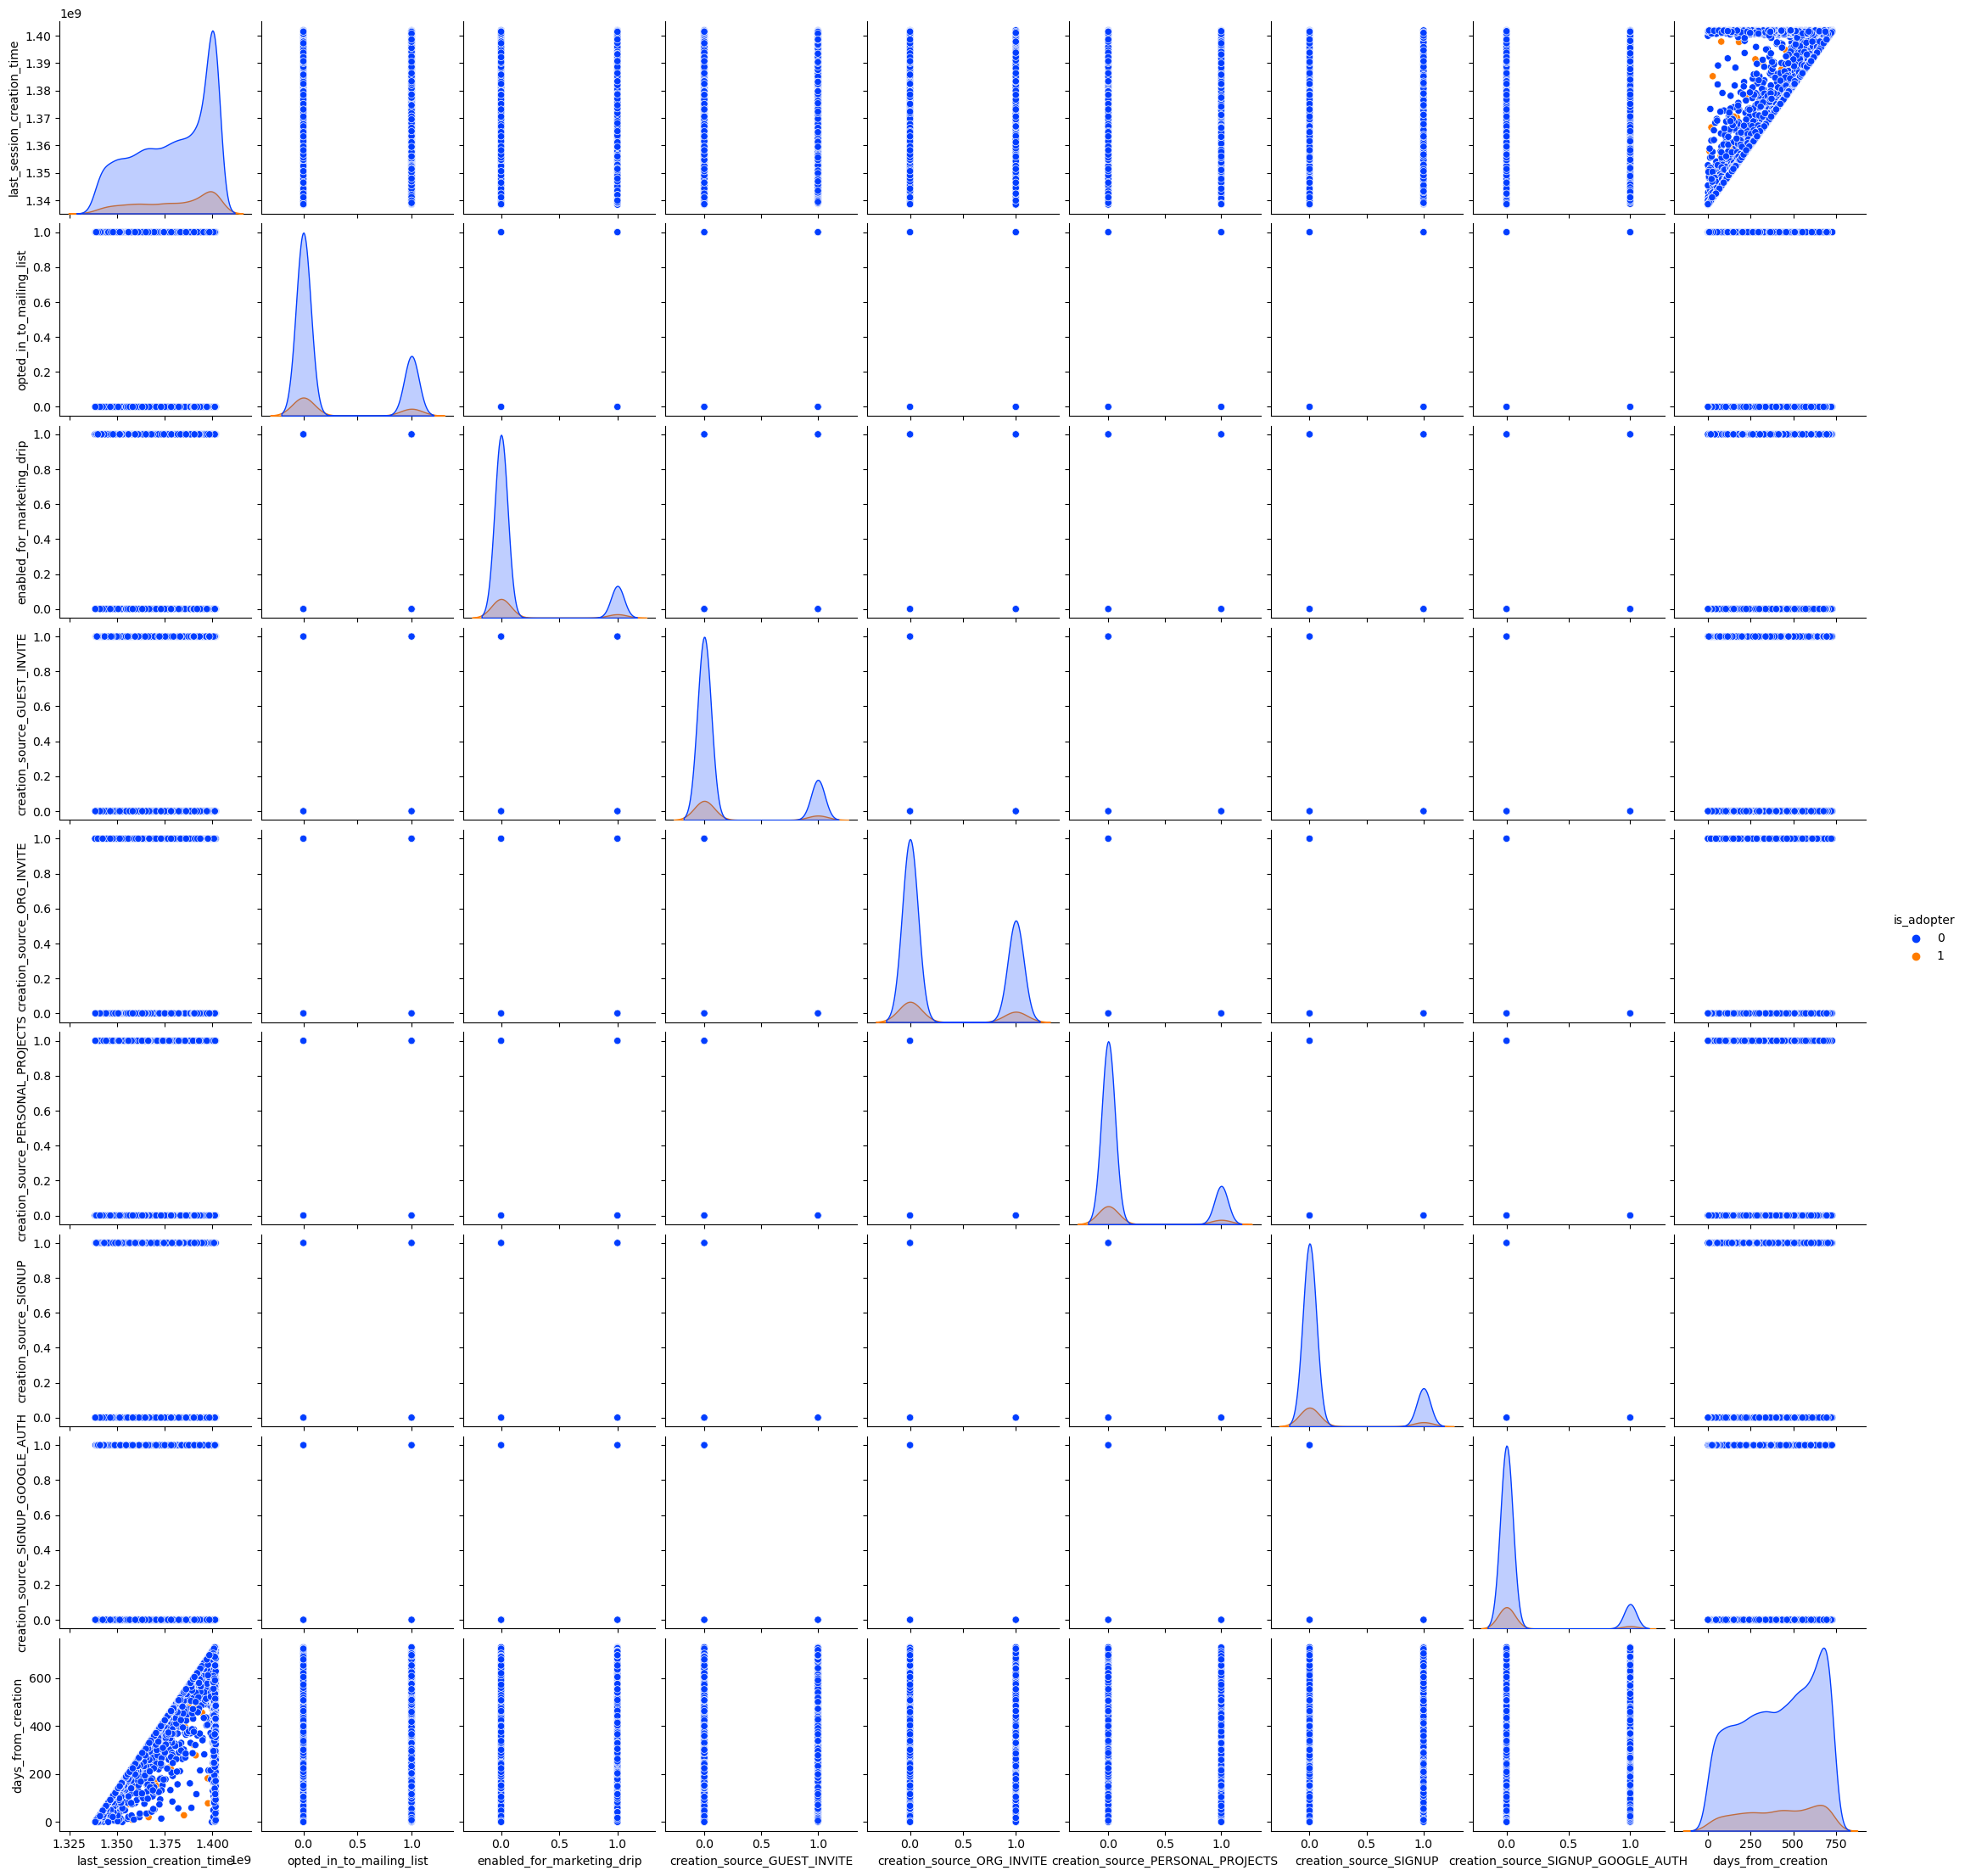

In [38]:
pairplot = sns.pairplot(numeric_users, hue = 'is_adopter', palette = 'bright')

In [ ]:
#use logistic regression model
X = numeric_users.drop('is_adopter', axis = 1)
y = users['is_adopter']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .3, random_state = 42)
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))